In [39]:
import torch
import numpy as np
from numpy.ma.core import outer
from sys import stderr
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.pyplot import scatter, figure
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(4, 4)})

import warnings

warnings.filterwarnings('ignore')


batch_size = 16

class Experiment(nn.Module):
    def __init__(self):
        super(Experiment, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        print(self.device)

        self.optimizer = None
        self.train_loss_history = []
        self.w_ic = 1.5
        self.w_int = 1
        self.w_data = 1
        self.w_bc = 1.5
        self.w_param_std = 1.0
        self.numInputs = 2
        self.numParams = 2
        self.numOutputs = 1
        self.hidden_size = 25

        self.t0 = torch.tensor([0.0], requires_grad=True).to(self.device)
        self.y0 = torch.tensor([1.0], requires_grad=True).to(self.device)

        self.predicted_params = torch.zeros((self.numParams,1), requires_grad=True, device=self.device)

        # We only have 1 input feature
        self.b1 = nn.Linear(self.numInputs, self.hidden_size).to(self.device)
        self.b2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.b3 = nn.Linear(self.hidden_size, self.numOutputs).to(self.device)

        self.t1 = nn.Linear(1, self.hidden_size).to(self.device)
        self.t2 = nn.Linear(self.hidden_size, self.hidden_size).to(self.device)
        self.t3 = nn.Linear(self.hidden_size, self.numParams).to(self.device)

        nn.init.ones_(self.b1.weight)
        nn.init.ones_(self.b2.weight)
        nn.init.ones_(self.b3.weight)

        nn.init.ones_(self.t1.weight)
        nn.init.ones_(self.t2.weight)
        nn.init.ones_(self.t3.weight)

    # make this static so that it can be called independently
    @staticmethod
    def exact_solution(t, x):
        return torch.exp(-t) * torch.sin(torch.pi * x)

    def forward(self, t, x):
        if not torch.is_tensor(t):
            t = torch.from_numpy(t).float().to(self.device)

        if not torch.is_tensor(x):

            x = torch.from_numpy(x).float().to(self.device)


        input = torch.cat((t, x), 1)

        h1 = torch.tanh(self.b1(input))
        h2 = torch.tanh(self.b2(h1))

        prior_param_sample = torch.rand(1, 1, device=self.device).requires_grad_(True)

        t1 = torch.tanh(self.t1(prior_param_sample))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_sample = self.t3(t2)

        self.predicted_params = posterior_param_sample.view(-1)

        y = self.b3(torch.multiply(t2, h2))

        return y

#     def sample_parameter_posterior(self, num_samples=100):
#         prior_param_sample = torch.rand(num_samples, 1, device=self.device).requires_grad_(True)
#         posterior_param_sample = self.t3(torch.tanh(self.t2(torch.tanh(self.t1(prior_param_sample)))))
#         return posterior_param_sample

    def sample_parameter_posterior(self, num_samples=100):
        prior_param_samples = torch.rand(num_samples, 1, device=self.device).requires_grad_(True)
        t1 = torch.tanh(self.t1(prior_param_samples))
        t2 = torch.tanh(self.t2(t1))
        posterior_param_samples = self.t3(t2)
        return posterior_param_samples

    def update_predicted_params(self, posterior_samples):
        mean = torch.mean(posterior_samples, dim=0)  # Compute the mean along the first axis
        std = torch.std(posterior_samples, dim=0)    # Compute the standard deviation along the first axis
        self.predicted_params = mean
        self.std_params = std  # Attach the standard deviation as an attribute

    # General formula to compute the n-th order derivative of y = f(x) with respect to x
    def compute_derivative(self, y, x, n):
        if n == 0:
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y, device= self.device),
                                        create_graph=True, retain_graph=True,
                                        allow_unused=True)[0]

        return self.compute_derivative(dy_dx, x, n - 1)

    def PDE_residual(self, t, x):
        y = self.forward(t, x)
        dy_dt = self.compute_derivative(y, t, 1)
        dy_dx = self.compute_derivative(y, x, 1)
        d2y_dx2 = self.compute_derivative(y, x, 2)

        residual = dy_dt - self.predicted_params[0] * d2y_dx2 \
            + torch.exp(-self.predicted_params[1] * t) * (torch.sin(torch.tensor(np.pi) * x) - torch.tensor(np.pi) ** 2 * torch.sin(torch.tensor(np.pi) * x))

        return residual

    def loss_initial_condition(self, num_samples=200):
        t0 = self.t0 * torch.ones((num_samples, 1), device = self.device)
        x = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        y0_pred = self.forward(t0, x)
        y0_true = self.exact_solution(t0, x)
        loss_ic = torch.mean(torch.square(y0_true - y0_pred))
        return loss_ic

    def loss_boundary_condition(self, num_samples=200):
        x_low = -1
        x_high = 1
        xb_low   = x_low * torch.ones((num_samples, 1),  device = self.device)
        xb_high  = x_high * torch.ones((num_samples, 1), device = self.device)

        t = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True) - 1.0

        yb_low = self.exact_solution(t, xb_low)
        yb_high = self.exact_solution(t, xb_high)

        yb_pred_low = self.forward(t, xb_low)
        yb_pred_high = self.forward(t, xb_high)

        loss_ic = torch.mean(torch.square(yb_pred_low - yb_low)) \
                + torch.mean(torch.square(yb_pred_high - yb_high))

        return loss_ic

    def compute_losses(self):
        loss_ic = self.loss_initial_condition()
        loss_interior = self.loss_interior()
        loss_data = self.loss_data()
        loss_bc = self.loss_boundary_condition()
        return loss_ic, loss_interior, loss_data, loss_bc

    def loss_data(self, num_samples=100):
        t_data, x_data, y_data = next(iter(train_loader))
        y_pred = self.forward(t_data, x_data)
        loss = torch.mean(torch.square(y_pred - y_data))
        return loss

    def loss_interior(self, num_samples=500):


        interior_t_samples = torch.rand((num_samples, 1),   device=self.device).requires_grad_(True)
        interior_x_samples = 2*torch.rand((num_samples, 1), device=self.device).requires_grad_(True)  - 1.0
        res = self.PDE_residual(interior_t_samples, interior_x_samples)
        loss_residual = torch.mean(torch.square(res))
        return loss_residual

#     def closure(self):
#         self.optimizer.zero_grad()
#         loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
#         total_loss = self.w_ic * loss_ic \
#                    + self.w_int * loss_interior \
#                    + self.w_data * loss_data \
#                    + self.w_bc * loss_bc

#         total_loss.backward(retain_graph=True)
#         return total_loss

    def closure(self):
        self.optimizer.zero_grad()
        loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
        total_loss = self.w_ic * loss_ic \
                   + self.w_int * loss_interior \
                   + self.w_data * loss_data \
                   + self.w_bc * loss_bc

        # Sample the parameter posterior and update self.predicted_params and self.std_params
        posterior_samples = self.sample_parameter_posterior(100)
        self.update_predicted_params(posterior_samples)

        # Add the (Log(std))**2 term to the loss with the specified weight
        log_std_squared_loss = self.w_param_std * torch.mean(torch.log(self.std_params)**2)
        total_loss += log_std_squared_loss

        total_loss.backward(retain_graph=True)
        return total_loss

#     def train(self, epochs, optimizer='Adam', **kwargs):
#         if optimizer == 'Adam':
#             self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

#         elif optimizer == 'L-BFGS':
#             self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

#         # Training loop
#         for epoch in range(epochs):
#             self.optimizer.step(self.closure)
#             if epoch % 4000 == 0:
#                 loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
#                 total_loss = loss_ic + loss_interior + loss_data + loss_bc
#                 print(f'Epoch ({optimizer}): {epoch},  Total Loss: {total_loss.detach().cpu().numpy()},\t' \
#                         f'PDE Loss: {loss_interior.detach().cpu().numpy()} \t' \
#                         f'BC Loss:  {loss_bc.detach().cpu().numpy()}\t' \
#                         f'IC Loss:  {loss_ic.detach().cpu().numpy()}\t' \
#                         f'Predicted Param: {net.predicted_params.detach().cpu().numpy()}\t')


    def train(self, epochs, optimizer='Adam', num_samples=100, **kwargs):
        if optimizer == 'Adam':
            self.optimizer = torch.optim.Adam(self.parameters(), **kwargs)

        elif optimizer == 'L-BFGS':
            self.optimizer = torch.optim.LBFGS(self.parameters(), **kwargs)

        # Training loop
        for epoch in range(epochs):
            self.optimizer.step(self.closure)
            if epoch % 4000 == 0:
                loss_ic, loss_interior, loss_data, loss_bc = self.compute_losses()
                total_loss = loss_ic + loss_interior + loss_data + loss_bc

                # Sample the parameter posterior and update self.predicted_params and self.std_params
                posterior_samples = self.sample_parameter_posterior(num_samples)
                self.update_predicted_params(posterior_samples)

                print(f'Epoch ({optimizer}): {epoch},  Total Loss: {total_loss.detach().cpu().numpy()},\t' \
                        f'PDE Loss: {loss_interior.detach().cpu().numpy()} \t' \
                        f'BC Loss:  {loss_bc.detach().cpu().numpy()}\t' \
                        f'IC Loss:  {loss_ic.detach().cpu().numpy()}\t' \
                        f'Predicted Param: {self.predicted_params.detach().cpu().numpy()}\t' \
                        f'Std Params: {self.std_params.detach().cpu().numpy()}')

In [40]:
def sample_dataset(noise=0.1, numSamples=100, device='cpu'):
    t = torch.linspace(0, 1, numSamples, device=device) # Time domain
    x = torch.linspace(-1, 1, numSamples, device=device) # Space domain

    T, X   = torch.meshgrid(t, x) # Time-Space domain

    y_true = Experiment.exact_solution(T, X)
    T      = T.reshape(-1, 1) # Reshape to 2D to 1D
    X      = X.reshape(-1, 1) # Resahpe to 2D to 1D

    sample_mean = y_true.reshape(-1, 1)
    sample_var  = noise * torch.ones_like(sample_mean)
    Y_noisy     = torch.normal(sample_mean, sample_var)

    return T, X, Y_noisy


def create_train_test_datasets(device='cpu'):
    t_train, x_train, y_train = sample_dataset(noise=0.01, numSamples=10, device=device)
    t_test, x_test, y_test = sample_dataset(noise=0.0, numSamples=100, device=device)

    fig = plt.figure()
    size = int(t_test.size(0)**0.5)


    plt.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy())
    plt.xlabel('t'); plt.ylabel('x');
    plt.colorbar()

    train_dataset = TensorDataset(t_train, x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t_test, x_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader


def plot_residuals(net, device, noise=0.0):
    t_test, x_test, y_test = sample_dataset(noise=noise, device=device)
    mu = net.forward(t_test, x_test)

    fig = plt.figure(figsize=(6, 3))
    ax1 = plt.subplot(121)
    size = int(np.sqrt(x_test.size(0)))

    # Calculate the residuals (difference between predictions and ground truth)
    residuals = (mu - y_test).view(size, size).cpu().detach().numpy()

    # Create a contour plot of the residuals
    cax = ax1.contourf(t_test.view(size, size).cpu().detach().numpy(),
                       x_test.view(size, size).cpu().detach().numpy(),
                       residuals)

    plt.colorbar(cax)
    plt.xlabel('t');plt.ylabel('x')
    plt.show()


def make_plot(net, device):
    t_test, x_test, y_test = sample_dataset(noise=0.0, device=device)
    mu = net.forward(t_test, x_test)

    fig = plt.figure(figsize=(6, 3))
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122, sharex=ax1)
    size = int(np.sqrt(x_test.size(0)))

    ax1.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 mu.view(size, size).cpu().detach().numpy())

    plt.xlabel('t')
    plt.ylabel('x')

    ax2.contourf(t_test.view(size, size).cpu().detach().numpy(),
                 x_test.view(size, size).cpu().detach().numpy(),
                 y_test.view(size, size).cpu().detach().numpy())

    plt.show()

In [41]:
net = Experiment()
net.to(net.device)
print("Params:", sum(p.numel() for p in net.parameters() if p.requires_grad))

cpu
Params: 1503


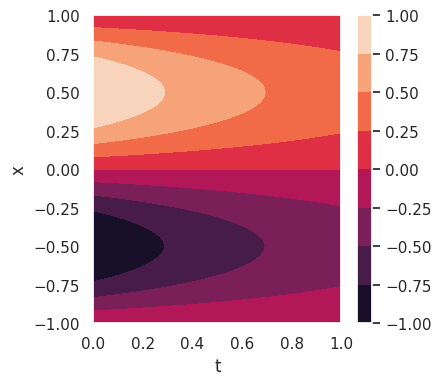

In [42]:
train_loader, test_loader = create_train_test_datasets(device = net.device)

In [43]:
net.w_ic = 1
net.w_data = 1
net.w_bc   = 1
net.w_param_std = 1

In [44]:
net.train(70000, optimizer='Adam', lr=1e-3)

Epoch (Adam): 0,  Total Loss: 2317646848.0,	PDE Loss: 2317644544.0 	BC Loss:  1224.357666015625	IC Loss:  563.3300170898438	Predicted Param: [23.946697 23.626266]	Std Params: [4.997627  5.0076323]
Epoch (Adam): 4000,  Total Loss: 1050863.875,	PDE Loss: 1050213.75 	BC Loss:  297.5654602050781	IC Loss:  157.8520965576172	Predicted Param: [16.09518  23.107018]	Std Params: [2.8500483 4.0850787]
Epoch (Adam): 8000,  Total Loss: 116507.7109375,	PDE Loss: 115989.0859375 	BC Loss:  303.2000427246094	IC Loss:  116.57637023925781	Predicted Param: [13.146499 22.909151]	Std Params: [2.275563  3.9177043]
Epoch (Adam): 12000,  Total Loss: 11574.4267578125,	PDE Loss: 11317.470703125 	BC Loss:  158.2105255126953	IC Loss:  49.208770751953125	Predicted Param: [10.514502 23.513744]	Std Params: [1.0705353 2.3278618]
Epoch (Adam): 16000,  Total Loss: 1266.63427734375,	PDE Loss: 1166.859375 	BC Loss:  77.54403686523438	IC Loss:  9.542340278625488	Predicted Param: [ 7.471656 22.335108]	Std Params: [1.8203684

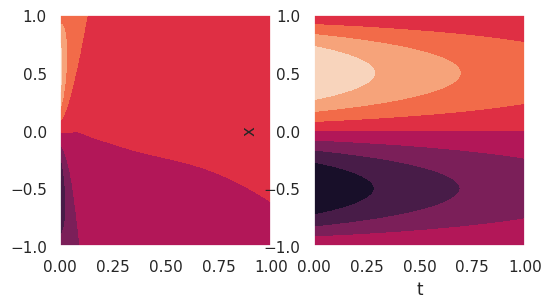

In [45]:
make_plot(net, device=net.device)

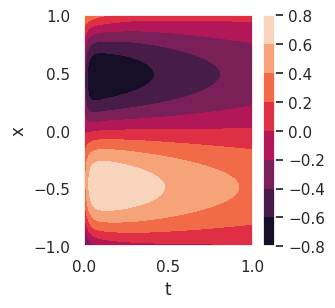

In [46]:
plot_residuals(net, device=net.device, noise=0.0)

In [47]:
samples = net.sample_parameter_posterior(num_samples=100)

In [48]:
samples.mean(axis=0), samples.std(axis=0)

(tensor([ 4.7941, 86.7604], grad_fn=<MeanBackward1>),
 tensor([0.9337, 0.9995], grad_fn=<StdBackward0>))

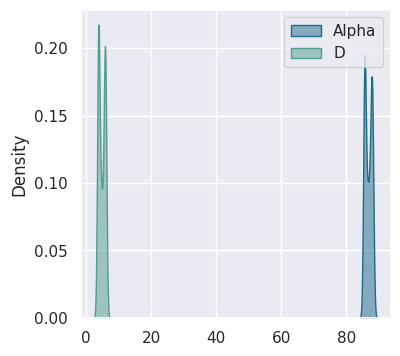

In [49]:
g  = sns.kdeplot(samples.cpu().data, fill=True, palette="crest",
                 alpha=.5, linewidth=1)
g.legend( ['Alpha','D'])

In [50]:
x = torch.linspace(-1, 1, 100).reshape(-1, 1)
t = torch.linspace(0, 1, 100).reshape(-1, 1)

X, T = torch.meshgrid(x[:, 0], t[:, 0])

y_true = Experiment.exact_solution(T, X)

In [51]:
# net(t,x);